
## <font color='red'>0.0. Imports</font> 

### 0.1. Libs

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
import re 

from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.cluster import KMeans
from sklearn import preprocessing as pp
from sklearn import metrics as m
from plotly import express as px


/home/las/Documentos/repos/ds_clusterizacao/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.2. Load data

In [2]:
# Load the dataset
df_raw = pd.read_csv('../data/Ecommerce.csv', sep=',', encoding='latin1')

# drop the 'Unnamed: 8' column
df_raw.drop(columns=['Unnamed: 8'], inplace=True)


In [3]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## <font color='red'>1.0. Descrição dos Dados</font> 

In [5]:
df1 = df_raw.copy()

### 1.1. Renomeando Colunas

In [6]:
df1.columns = new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
188647,553052,23174,REGENCY SUGAR BOWL GREEN,24,11-May-17,3.75,15251.0,United Kingdom


### 1.2. Dimensão dos Dados


In [7]:
print(f'Total de linhas:{df1.shape[0]}')
print(f'Total de colunas:{df_raw.shape[1]}')

Total de linhas:541909
Total de colunas:8


### 1.3. Tipo dos Dados

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4. Verificando dados nulos

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5. Substituindo dados nulos

In [10]:
# Remove rows with NaN values in 'customer_id' and 'description'
df_na = df1.dropna(subset=['customer_id', 'description'])

# proportion of NaN values in 'customer_id' and 'description'
print(f'Dados removidos: { ( 1 - ( df_na.shape[0] / df_raw.shape[0] ) ) * 100:.2f}%')

Dados removidos: 24.93%


In [11]:
# EXPLICAR O RACIONAL PARA A ESCOLHA DO CÓDIGO ABAIXO

df_missing = df1.loc[df1['customer_id'].isna(), : ]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :  ]

In [12]:
# Criando referencia
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000 + len( df_backup ), 1 )

# Merge the backup DataFrame with the original DataFrame
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce the 'customer_id' column

df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.6. Alterando tipo os dados

In [13]:
# invoice_date to datetime
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer_id to int
df1['customer_id'] = df1['customer_id'].astype( int )

print(f'{df1.dtypes}\n')
df1.head()

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object



,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


### 1.7. Estatística Descritiva

In [14]:
num_atributes = df1.select_dtypes( include=['int64','float'])
cat_atributes = df1.select_dtypes( exclude=['int64','float'])


#### 1.7.1. Atributos numéricos

In [15]:
# Tendencia central
mean_ = pd.DataFrame( num_atributes.apply( np.mean) ).T
median_ = pd.DataFrame( num_atributes.apply( np.median ) ).T

# Medidas de dispersão
std_ = pd.DataFrame( num_atributes.apply( np.std ) ).T
min_ = pd.DataFrame( num_atributes.apply( np.min ) ).T
max_ = pd.DataFrame( num_atributes.apply( np.max ) ).T
range_ = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min() ) ).T
skew_ = pd.DataFrame( num_atributes.apply( lambda x: x.skew() ) ).T
kurtosis_ = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() ) ).T

# Conatenate all statistics into a single DataFrame
medi = pd.concat( [min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
medi.columns = ['atributes','min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
medi


,atributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


##### <font color='red'>1.7.1.1. Numerical Atributs - Investigating </font>

1. Quantity negativa ( pode ser devolução )
2. Preço unitário igual a zero ( pode ser promoção )


#### 1.7.2 Atributos categóricos

In [16]:
cat_atributes

,invoice_no,stock_code,description,invoice_date,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2016-11-29,United Kingdom
1,536365,71053,WHITE METAL LANTERN,2016-11-29,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2016-11-29,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2016-11-29,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2016-11-29,United Kingdom
...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,2017-12-07,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,2017-12-07,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,2017-12-07,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,2017-12-07,France


Invoice No

In [17]:
# problema: Temos invoice com letras e numeros
# df1['invoice_no'].astype('int')

#identificador de invoice com letras e numeros
df_letter_invoices = df1.loc[ df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9+]', x  ) ) ), : ]

print(f'Total de invoices com letras: {df_letter_invoices.shape[0]}')
print('Total de quantity negativos: {} '.format(df_letter_invoices[ df_letter_invoices['quantity'] < 0].shape[0] ))

Total de invoices com letras: 9291
Total de quantity negativos: 9288 


Stock Code

In [18]:
# Verificando se o stock_code tem letras
df1.loc[ df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+', x ) ) ), 'stock_code' ].unique()

# Acção: 
## 1. Remover as linhas com invoice_no que possuem letras ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

Description

In [19]:
df1.head()

# Ação: Deletar a descrição dos produtos por não ser relevantes para a análise

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


Country


In [20]:
print(f'Total de países: { len( df1.country.unique() ) }\n' )
print(f'Nome países: {df1.country.unique()}')

# Ação é remover os países que não são relevantes para a análise, como 'Unspecified',  'European Community'

Total de países: 38

Nome países: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


In [21]:
# Representação percentual dos países
df1.country.value_counts (normalize=True )

country
United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
Eu

In [22]:
# df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

# <font color='red'>2.0. Filtragem de Variáveis</font> 

In [23]:
df2 = df1.copy()

In [24]:
# *** Atributos numéricos ***
## Filtrando unit_price para valores maiores que 0.04

df2 = df2.loc[ df2['unit_price'] > 0.04, : ]


# *** Atributos categóricos ***
## Remover as linhas com stock_code que possuem letras ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

df2 = df2[ ~df2['stock_code'].isin( [   'POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
                                        'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
                                        'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
                                        'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
                                        'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
                                        'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'
                                    ] ) ]


# *** Atributos categóricos ***
## Remover a coluna 'description' por não ser relevante para a análise

df2 = df2.drop(columns='description', axis=1 )

## Remover os países 'Unspecified' e 'European Community' por não serem relevantes para a análise

df2 = df2[ ~df2['country'].isin( ['Unspecified','European Community'] ) ]


# *** Atributos numéricos ***
## Separar os dados de compra e devolução através do atributo 'quantity'

df2_return = df2.loc[ df2['quantity'] < 0, : ]
df2_purchases = df2.loc[ df2['quantity'] > 0, : ]





In [25]:
    # df2.loc[  df2['unit_price'] > 0.04,  ['customer_id', 'description','unit_price'] ].sort_values('unit_price',ascending=True).head(10)

# <font color='red'>03. Feature Engineering</font> 

In [26]:
# Feature ideas
## Moving average - 7d, 14d, 30d, 60d
## Quantidade de comprras por mês, antes do dia 15 e depois do dia 15

In [27]:
df3 = df2.copy()

In [44]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


In [45]:
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


#### 3.1.1. Gross Revenue


In [46]:
# Faturamento por cliente gros_re_revenue
df2_purchases.loc[ :, 'gros_revenue'] = df2_purchases.loc[ :,'quantity'] * df2_purchases.loc[ :,'unit_price']

df_monetary = df2_purchases.loc[ :, ['customer_id', 'gros_revenue'] ].groupby('customer_id').sum().reset_index()

# Merge df_ref com faturamento df_monetary
df_ref = df_ref.merge( df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gros_revenue    67
dtype: int64

#### 3.1.2. Recency - Day from last purchase

In [47]:
# Recencia
df_recency = df2_purchases.loc[ :, ['customer_id', 'invoice_date'] ].groupby('customer_id').max().reset_index()
df_recency['recence_days'] = ( df3['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_ref = df_ref.merge(df_recency[['customer_id', 'recence_days']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gros_revenue    67
recence_days    67
dtype: int64

#### 3.1.3. Qunatity of puchased

In [48]:
# Numero de Produtos
df_freq = df2_purchases.loc[ :, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename( columns={'invoice_no': 'qtde_invoices'})
df_ref = df_ref.merge(df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gros_revenue     67
recence_days     67
qtde_invoices    67
dtype: int64

#### 3.1.4. Qunatity of items puchasedd

In [49]:
# Numero de Produtos
df_freq = df2_purchases.loc[ :, ['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity': 'qtde_items'})
df_ref = df_ref.merge(df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gros_revenue     67
recence_days     67
qtde_invoices    67
qtde_items       67
dtype: int64

#### 3.1.5. Qunatity of products purchased

In [50]:
# Numero de Produtos
df_freq = df2_purchases.loc[ :, ['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename( columns={'stock_code': 'qtde_products'})
df_ref = df_ref.merge(df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gros_revenue     67
recence_days     67
qtde_invoices    67
qtde_items       67
qtde_products    67
dtype: int64

#### 3.1.5. Average Ticket Value

In [34]:
# Media do ticket
df_avg_ticket = df2_purchases.loc[ :, ['customer_id','gros_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gros_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id      0
gros_revenue    67
recence_days    67
invoice_no      67
quantity        67
avg_ticket      67
dtype: int64

#### 3.1.6. Average Recency Days

In [35]:
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values( [ 'customer_id', 'invoice_date'], ascending=[False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer_id
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice_date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['previous_date'] - x['invoice_date']  ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency days
df_avg_renceny_Days = df_aux.groupby('customer_id').mean().reset_index()

# merge df_ref with df_avg_recency_Days
df_ref = pd.merge( df_ref, df_avg_renceny_Days, on='customer_id', how='left' )
df_ref.isna().sum()


# df_aux.head()

customer_id            0
gros_revenue          67
recence_days          67
invoice_no            67
quantity              67
avg_ticket            67
avg_recency_days    2794
dtype: int64

#### 3.1.7. Frequency Purchase

In [36]:
df_aux = ( df2[['customer_id','invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(
                                                                                                        max_ = ('invoice_date', 'max'),
                                                                                                        min_ = ('invoice_date', 'min'),
                                                                                                        days_ = ('invoice_date', lambda x: ( ( x.max()  - x.min() ).days ) + 1 ),
                                                                                                        buy_ = ('invoice_no', 'count') ) ).reset_index()



# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

# Merge df_ref with df_aux
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gros_revenue          67
recence_days          67
invoice_no            67
quantity              67
avg_ticket            67
avg_recency_days    2794
frequency              0
dtype: int64

#### 3.1.8. Number os Returns

In [37]:
df2_returns = df2_return[['customer_id','quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'qtd_returns'} )
df2_returns['qtd_returns'] = df2_returns['qtd_returns'] * -1 # multiplicar por -1 para transformar em positivo

df_ref = pd.merge( df_ref, df2_returns, on='customer_id', how='left' )
df_ref.loc[ df_ref['qtd_returns'].isna(), 'qtd_returns' ] = 0 # preencher os valores NaN com 0
df_ref.isna().sum()

customer_id            0
gros_revenue          67
recence_days          67
invoice_no            67
quantity              67
avg_ticket            67
avg_recency_days    2794
frequency              0
qtd_returns            0
dtype: int64

#### 3.1.9.  Basket Size - Quantidade de items por cesta ( Quantity )

In [38]:
df_aux = ( df2_purchases.loc[ :, ['customer_id','invoice_no', 'quantity'] ].groupby('customer_id')
                                                                  .agg( n_purchases = ('invoice_no', 'nunique'),
                                                                        n_products = ('quantity', 'sum') )
                                                                  .reset_index() )
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# Merge df_ref with df_aux
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_basket_size']], on='customer_id', how='left' )
df_ref.isna().sum()




customer_id            0
gros_revenue          67
recence_days          67
invoice_no            67
quantity              67
avg_ticket            67
avg_recency_days    2794
frequency              0
qtd_returns            0
avg_basket_size       67
dtype: int64

#### 3.1.10. Unique Basket Size - Quantidade de produtos distintos por compra

In [39]:
df_aux = ( df2_purchases.loc[ :, ['customer_id','invoice_no', 'stock_code'] ].groupby('customer_id')
                                                                  .agg( n_purchases = ('invoice_no', 'nunique'),
                                                                        n_products = ('stock_code', 'count') )
                                                                  .reset_index() )

df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# Merge df_ref with df_aux
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_unique_basket_size']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id                  0
gros_revenue                67
recence_days                67
invoice_no                  67
quantity                    67
avg_ticket                  67
avg_recency_days          2794
frequency                    0
qtd_returns                  0
avg_basket_size             67
avg_unique_basket_size      67
dtype: int64

In [40]:
df_ref.head()

,customer_id,gros_revenue,recence_days,invoice_no,quantity,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,297.0,297.0,18.152222,35.500000,0.486111,40.0,50.970588,8.735294
1,13047,3232.59,56.0,171.0,171.0,18.904035,27.250000,0.048780,35.0,154.444444,19.000000
2,12583,6705.38,2.0,232.0,232.0,28.902500,23.187500,0.045699,50.0,335.200000,15.466667
3,13748,948.25,95.0,28.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,3.0,292.000000,8.600000,0.136364,22.0,26.666667,1.000000


# <font color='red'>4.0. EDA ( Exploratory Data Analysis )</font> 

In [41]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gros_revenue              0
recence_days              0
invoice_no                0
quantity                  0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtd_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

#### 4.1. Univariate Analysis

In [42]:
profile = ProfileReport(df4, title="Ecommerce Data Profiling Report", explorative=True)
profile.to_file("ecommerce_data_profiling_report.html")

/home/las/Documentos/repos/ds_clusterizacao/env/lib/python3.11/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 35.58it/s]


#### 4.2. Bivariate Analysis

# <font color='red'>5.0. Preparação dos Dados</font> 

In [ ]:
df5 = df4.copy()

In [ ]:
df5.head()

,customer_id,gros_revenue,recence_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,297.0,18.152222
1,13047,3232.59,56.0,171.0,18.904035
2,12583,6705.38,2.0,232.0,28.902500
3,13748,948.25,95.0,28.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


In [ ]:
## Satandardização dos dados
ss = pp.StandardScaler()

df5['gros_revenue'] = ss.fit_transform( df5[['gros_revenue']] )
df5['recence_days'] = ss.fit_transform( df5[['recence_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )

In [ ]:
df5.head()

,customer_id,gros_revenue,recence_days,invoice_no,avg_ticket
0,17850,0.377984,2.792381,0.901254,-0.033938
1,13047,0.135753,-0.361050,0.348743,-0.033427
2,12583,0.525455,-0.899927,0.616229,-0.026622
3,13748,-0.120587,0.028140,-0.278313,-0.023245
4,15100,-0.128694,2.403192,-0.387938,0.152422


# <font color='red'>6.0. Seleção de Features</font> 

In [ ]:
df6 = df5.copy()

# <font color='red'>7.0. Hypermarameter Fine-Tunning</font> 

In [ ]:
X = df6.drop( columns=['customer_id'] )

In [ ]:
clusters = [ 2, 3, 4, 5, 6, 7]

### 7.1. Within-Cluster Sum 0f Square ( WSS )

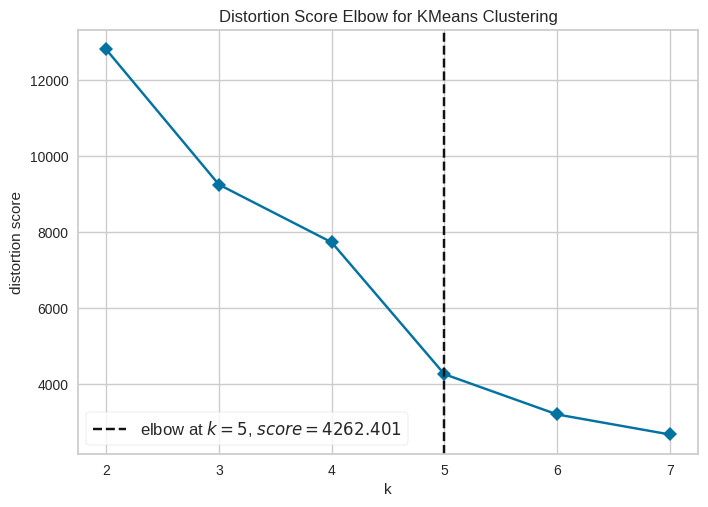

In [ ]:

# Cria o modelo base
model = KMeans()

# Cria o visualizador do cotovelo
kmeans = KElbowVisualizer(model, k=clusters, timings=False)

# Ajusta aos dados
kmeans.fit(X)

# Exibe o gráfico
kmeans.show();


### 7.2. Silhouette Score ( SS )

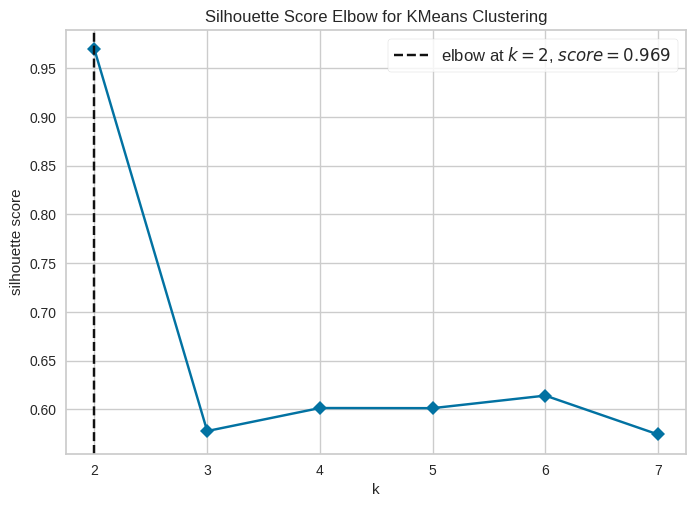

In [ ]:
# Cria o modelo com o número de clusters ideal
kmeans = KElbowVisualizer( model, k=clusters,  metric='silhouette', timings=False)

# Ajusta aos dados
kmeans.fit(X)

# Exibe o gráfico
kmeans.show();

### 7.3. Silhouette Analysis

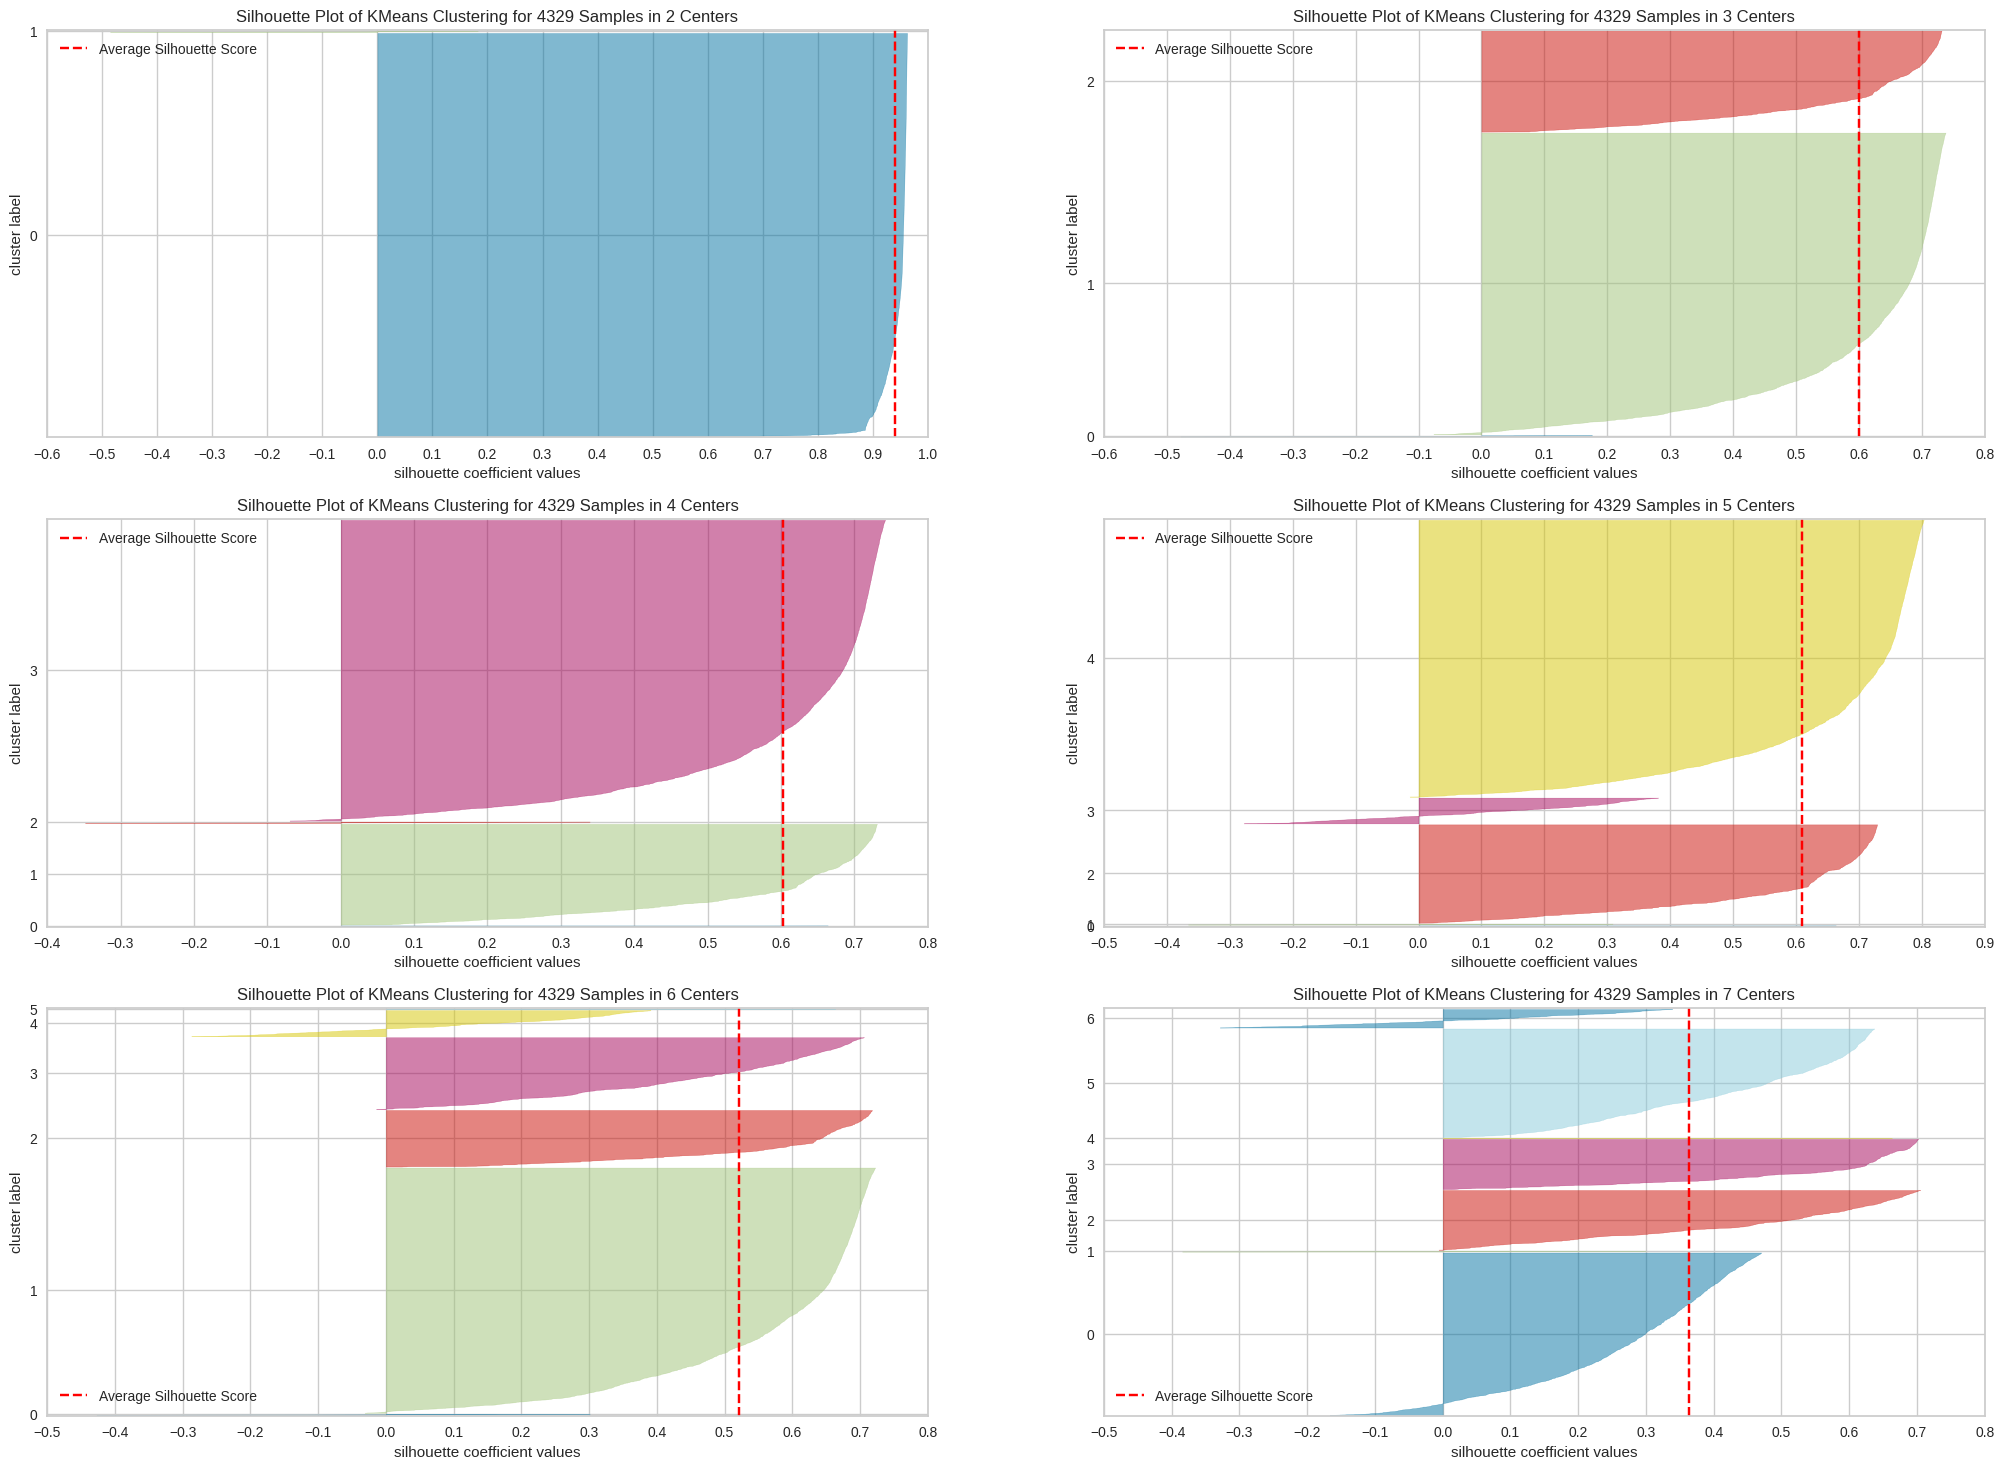

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))



for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )

    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize();

# <font color='red'>8.0. Model Training</font> 

### 8.1. K-Means

In [ ]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# cluster labels
labels = kmeans.labels_


### 8.2. Cluster Validation

In [ ]:
# WSS
print(f'WSS value: {kmeans.inertia_:.2f}')
# SS
print(f'SS value: {m.silhouette_score( X, labels, metric="euclidean" ) :.3f}')

WSS value: 9261.82
SS value: 0.600


# <font color='red'>9.0. Cluster Analysis</font> 

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels
# Visualize the clusters
df9.head()

,customer_id,gros_revenue,recence_days,invoice_no,avg_ticket,cluster
0,17850,0.377984,2.792381,0.901254,-0.033938,2
1,13047,0.135753,-0.361050,0.348743,-0.033427,1
2,12583,0.525455,-0.899927,0.616229,-0.026622,1
3,13748,-0.120587,0.028140,-0.278313,-0.023245,1
4,15100,-0.128694,2.403192,-0.387938,0.152422,2


### 9.1. Visualization Inspection 

/home/las/Documentos/repos/ds_clusterizacao/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


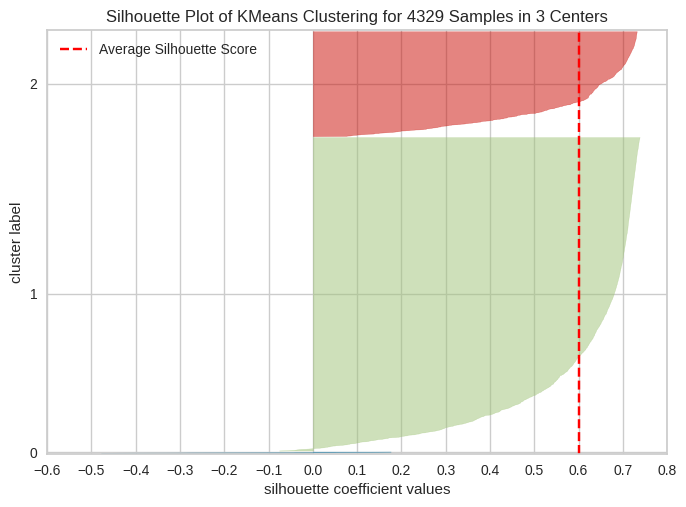

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

### 9.1. Visualization Inspection para 3 dimensões

In [ ]:
# import nbformat
# fig = px.scatter_3d(df9, x='gros_revenue', y='recence_days', z='invoice_no', color='cluster')

# fig.show()

### 9.2. 2d Plot

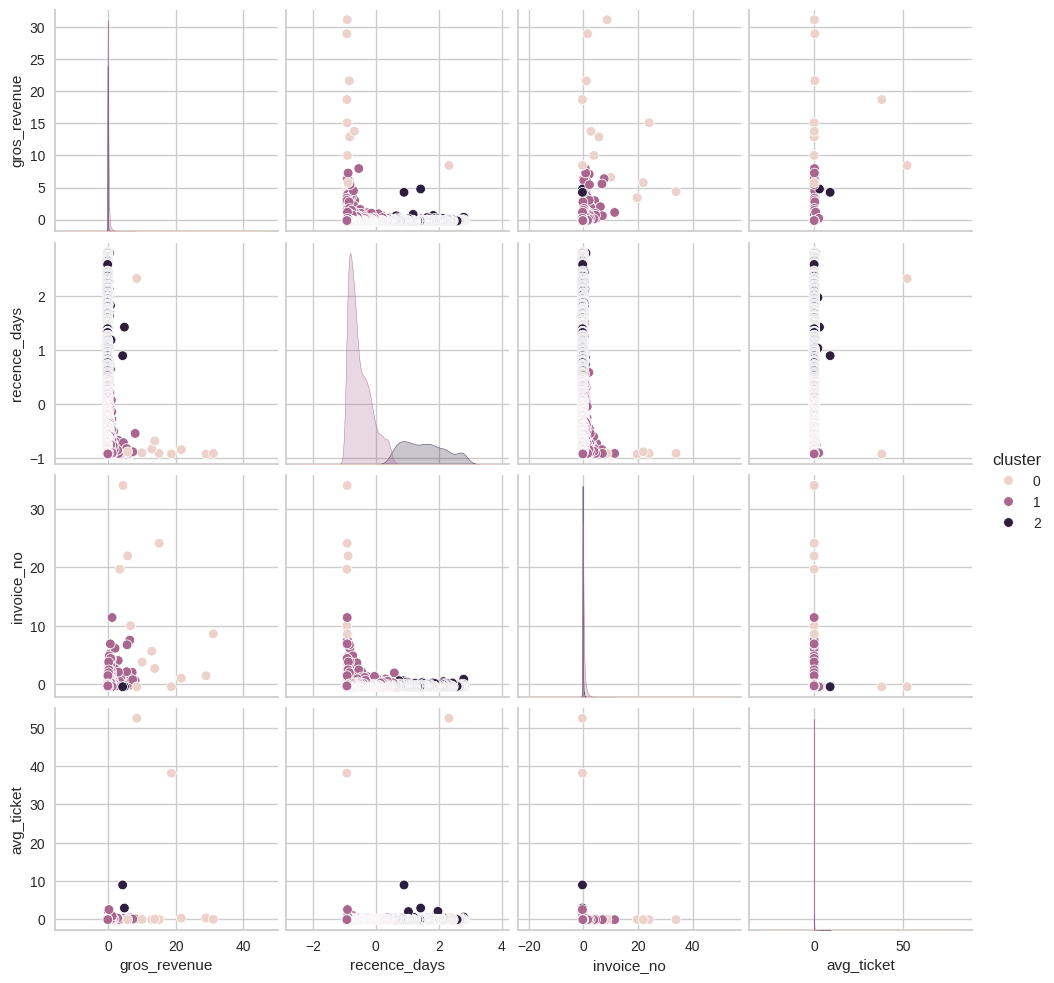

In [ ]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='cluster');

### 9.3. UMAP

/home/las/Documentos/repos/ds_clusterizacao/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/las/Documentos/repos/ds_clusterizacao/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='component_1', ylabel='component_2'>

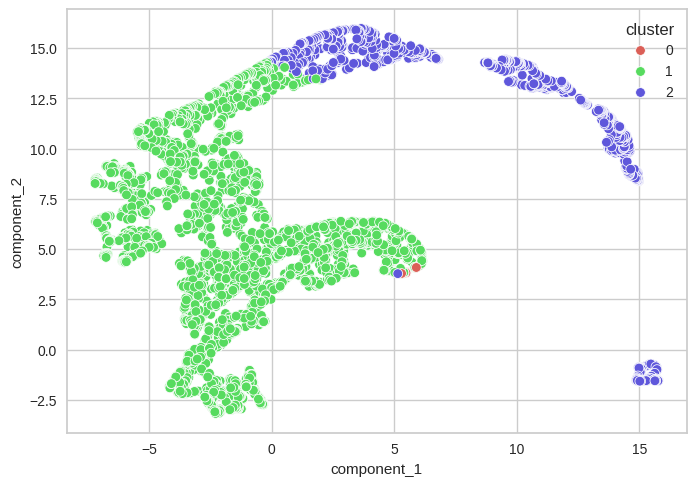

In [ ]:

reducer = umap.UMAP( n_neighbors= 20
                    , random_state=42)
embedding = reducer.fit_transform( X)

# embedding
df_viz['component_1'] = embedding[:, 0]
df_viz['component_2'] = embedding[:, 1]

# plot
sns.scatterplot( 
                x='component_1',
                y='component_2',
                hue='cluster',
                palette=sns.color_palette( 'hls', n_colors= len( df_viz['cluster'].unique() ) ),
                data=df_viz
            )


In [ ]:
df9.head()

,customer_id,gros_revenue,recence_days,invoice_no,avg_ticket,cluster
0,17850,0.377984,2.792381,0.901254,-0.033938,2
1,13047,0.135753,-0.361050,0.348743,-0.033427,1
2,12583,0.525455,-0.899927,0.616229,-0.026622,1
3,13748,-0.120587,0.028140,-0.278313,-0.023245,1
4,15100,-0.128694,2.403192,-0.387938,0.152422,2


In [ ]:
# Number od customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['%_customers'] = round( (df_cluster['customer_id'] / df_cluster['customer_id'].sum() ) * 100, 2 )

# Media de gros_revenue
df_avg_gros_revenue = round( df9[['gros_revenue', 'cluster']].groupby('cluster').mean().reset_index(), 2 )
df_cluster = df_cluster.merge(df_avg_gros_revenue, on='cluster', how='inner')

# Media de recence_days
df_avg_recence_days = round( df9[['recence_days', 'cluster']].groupby('cluster').mean().reset_index(), 2 )
df_cluster = df_cluster.merge(df_avg_recence_days, on='cluster', how='inner')

# Media de invoice_no
df_avg_invoice_no = round( df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index(), 0)
df_cluster = df_cluster.merge(df_avg_invoice_no, on='cluster', how='inner')
df_cluster.columns = ['cluster', 'n_customers', '%_customers', 'avg_gros_revenue', 'avg_recence_days', 'avg_invoice_no']
df_cluster = df_cluster.sort_values(by='cluster').reset_index(drop=True)

df_ticket = round( df9[['cluster','avg_ticket']].groupby('cluster').mean().reset_index(), 2)
df_cluster = pd.merge(df_cluster, df_ticket, on='cluster', how='left')
df_cluster

,cluster,n_customers,%_customers,avg_gros_revenue,avg_recence_days,avg_invoice_no,avg_ticket
0,0,13,0.30,13.89,-0.63,10.0,7.03
1,1,3234,74.71,-0.00,-0.51,0.0,-0.03
2,2,1082,24.99,-0.16,1.54,-0.0,-0.01


# <font color='red'>10.0. Deploy To Production</font> 